In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from fbprophet import Prophet


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
plant1_generation = pd.read_csv('../input/solar-power-generation-data/Plant_1_Generation_Data.csv')
plant1_weather = pd.read_csv('../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
plant2_generation = pd.read_csv('../input/solar-power-generation-data/Plant_2_Generation_Data.csv')
plant2_weather = pd.read_csv('../input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')

In [3]:
plant1_generation.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0    7158964.0

In [4]:
plant2_weather.tail()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
3254  2020-06-17 22:45:00   4136001  iq8k7ZNt4Mwm3w0            23.511703   
3255  2020-06-17 23:00:00   4136001  iq8k7ZNt4Mwm3w0            23.482282   
3256  2020-06-17 23:15:00   4136001  iq8k7ZNt4Mwm3w0            23.354743   
3257  2020-06-17 23:30:00   4136001  iq8k7ZNt4Mwm3w0            23.291048   
3258  2020-06-17 23:45:00   4136001  iq8k7ZNt4Mwm3w0            23.202871   

      MODULE_TEMPERATURE  IRRADIATION  
3254           22.856201          0.0  
3255           22.744190          0.0  
3256           22.492245          0.0  
3257           22.373909          0.0  
3258           22.535908          0.0

# Questions
- Can we predict the power generation for next couple of days? - this allows for better grid management

We can try, I'm inclined to use fbprophet for this as we have weekly data

- Can we identify the need for panel cleaning/maintenance?
- Can we identify faulty or suboptimally performing equipment?

I feel like these two questions go together. The way to identify a need for maintenance or fault detection is to build a trend of normal system performance (power output) in a given set of environmental conditions (time of day, weather etc). Any fall in power output indicates a need for maintenance/cleaning or the occurance of a fault. As we only have a month of data, this will be challenging to do properly...but hey, we can show how it would be done

# Visualisation

Lets look at the data and see if anything can be gleaned from it

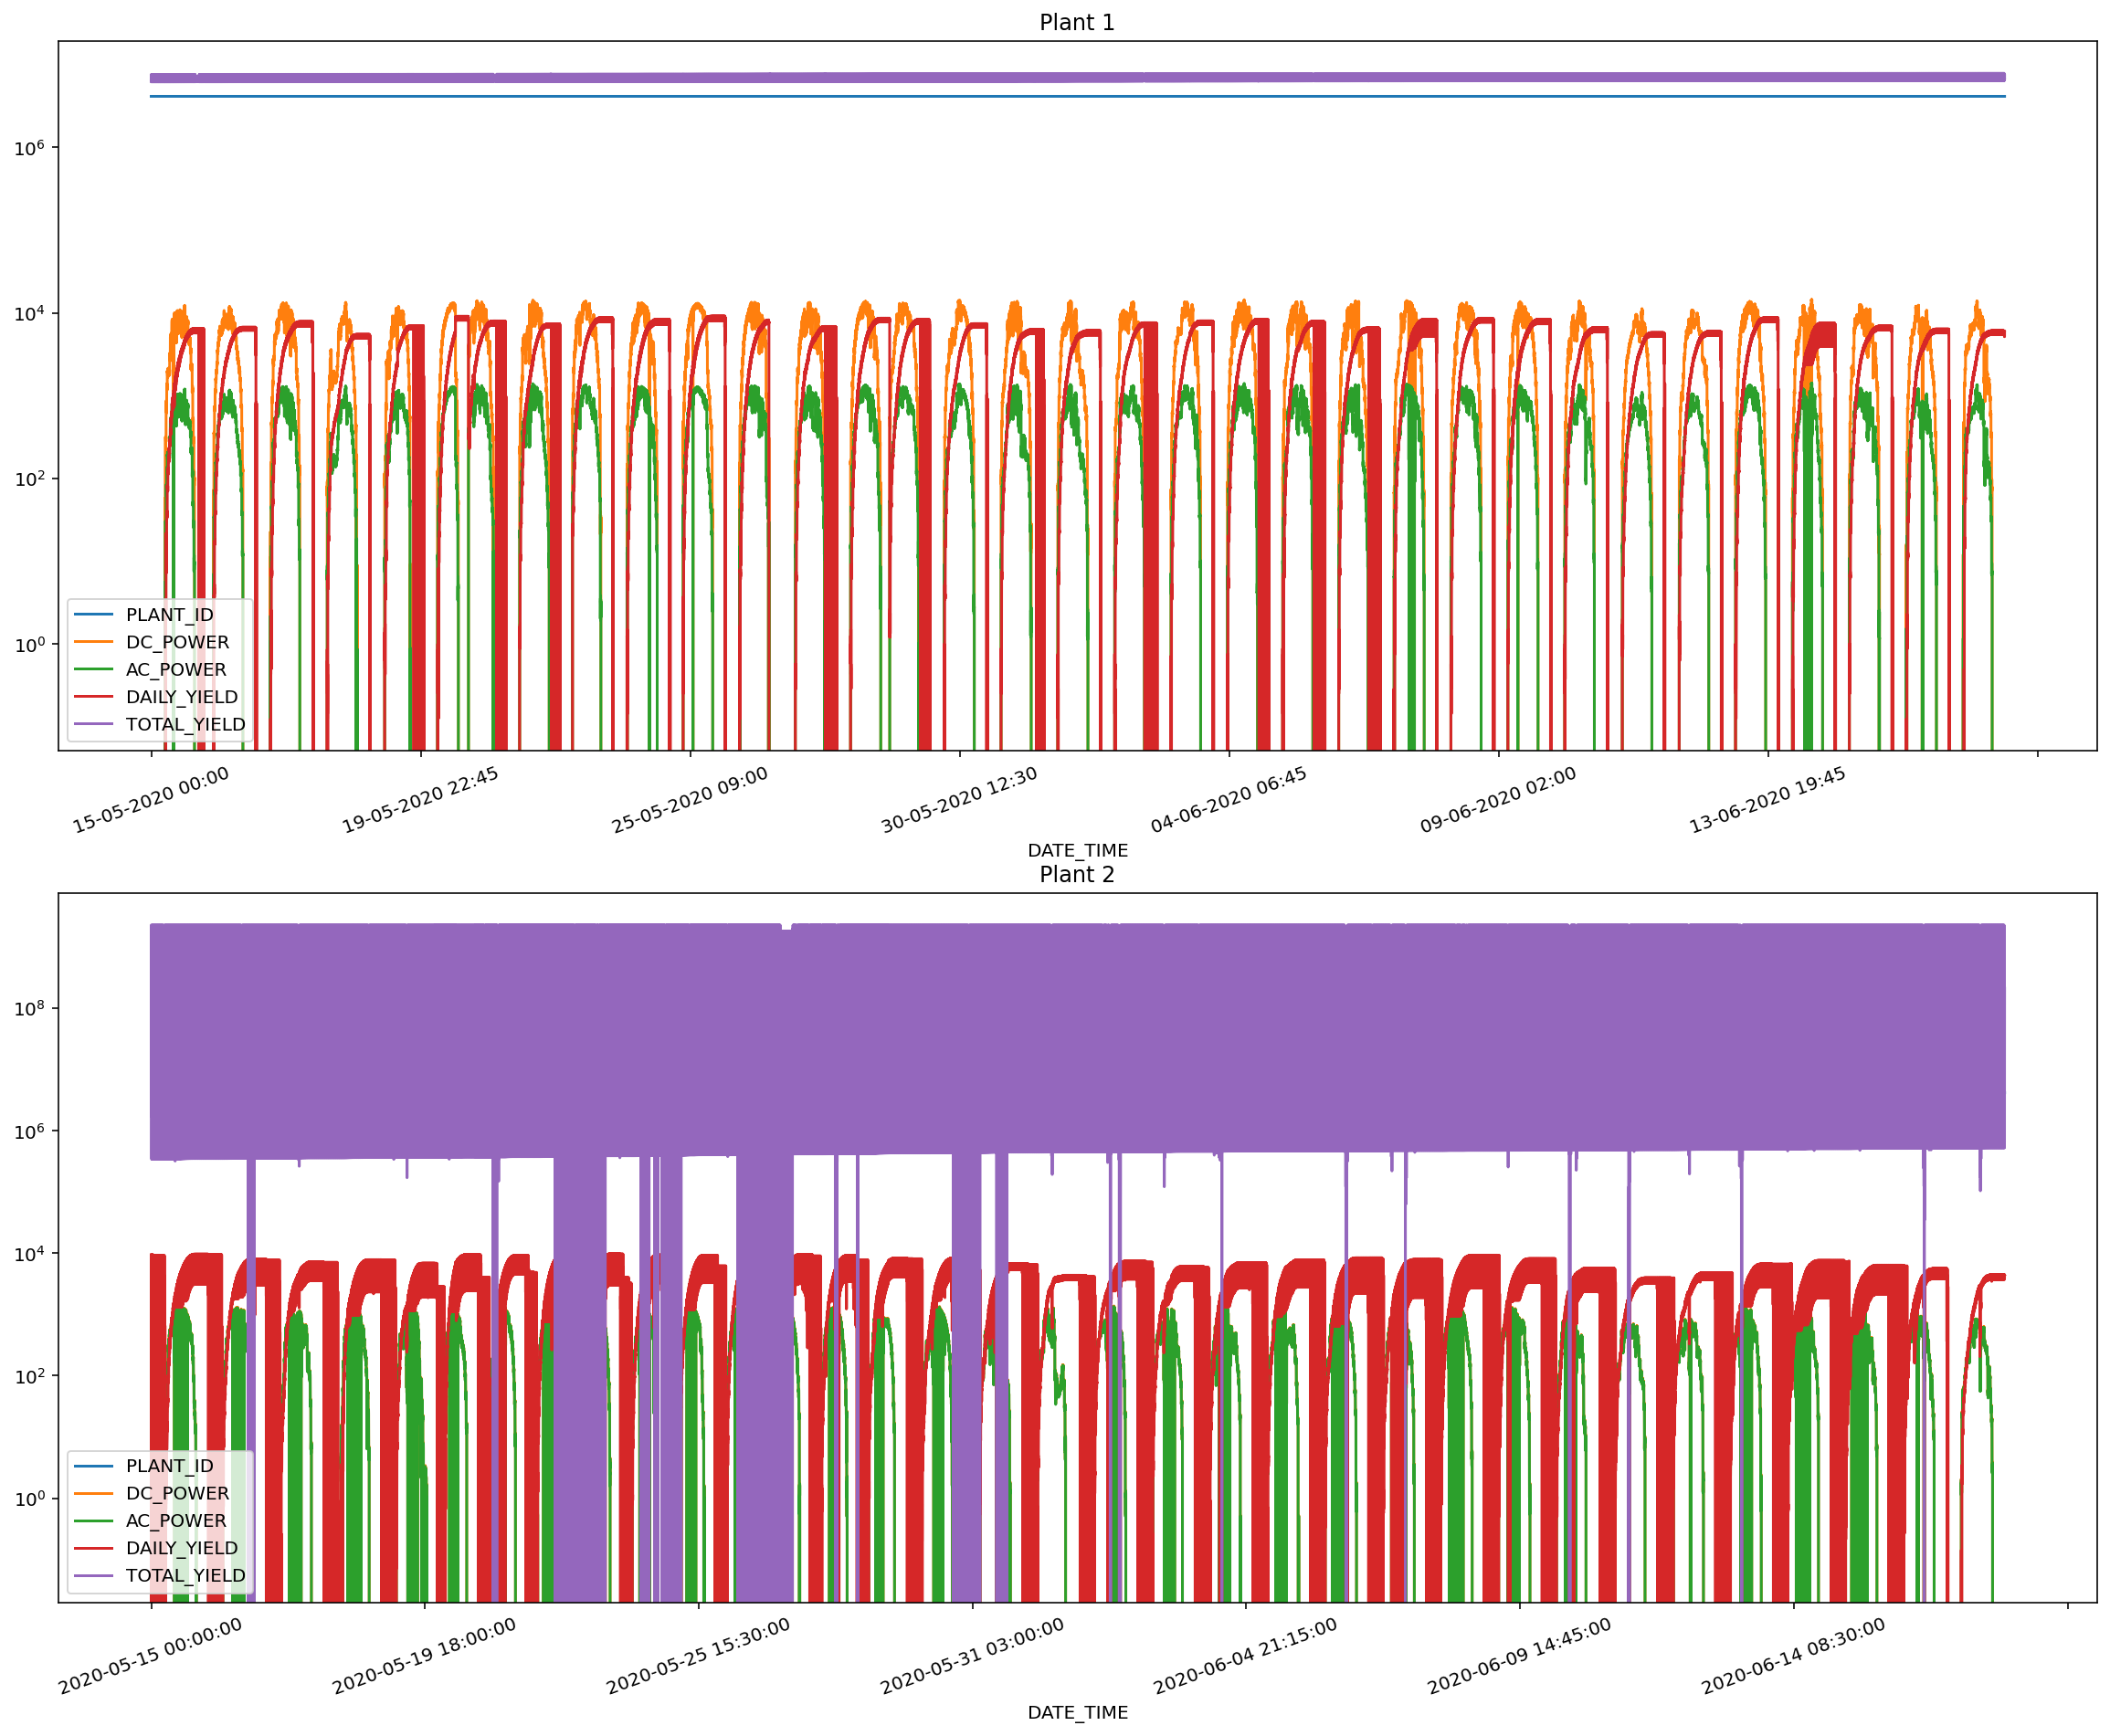

In [5]:
fig, axes = plt.subplots(nrows = 2, sharex=False, figsize=(20, 5))
fig.subplots_adjust(top = 2.5)
ax = plant1_generation.plot(x = 'DATE_TIME', logy = True, title = 'Plant 1', rot = 20, ax = axes[0]); 
ax = plant2_generation.plot(x = 'DATE_TIME', logy = True, title = 'Plant 2', rot = 20, ax = axes[1]); 

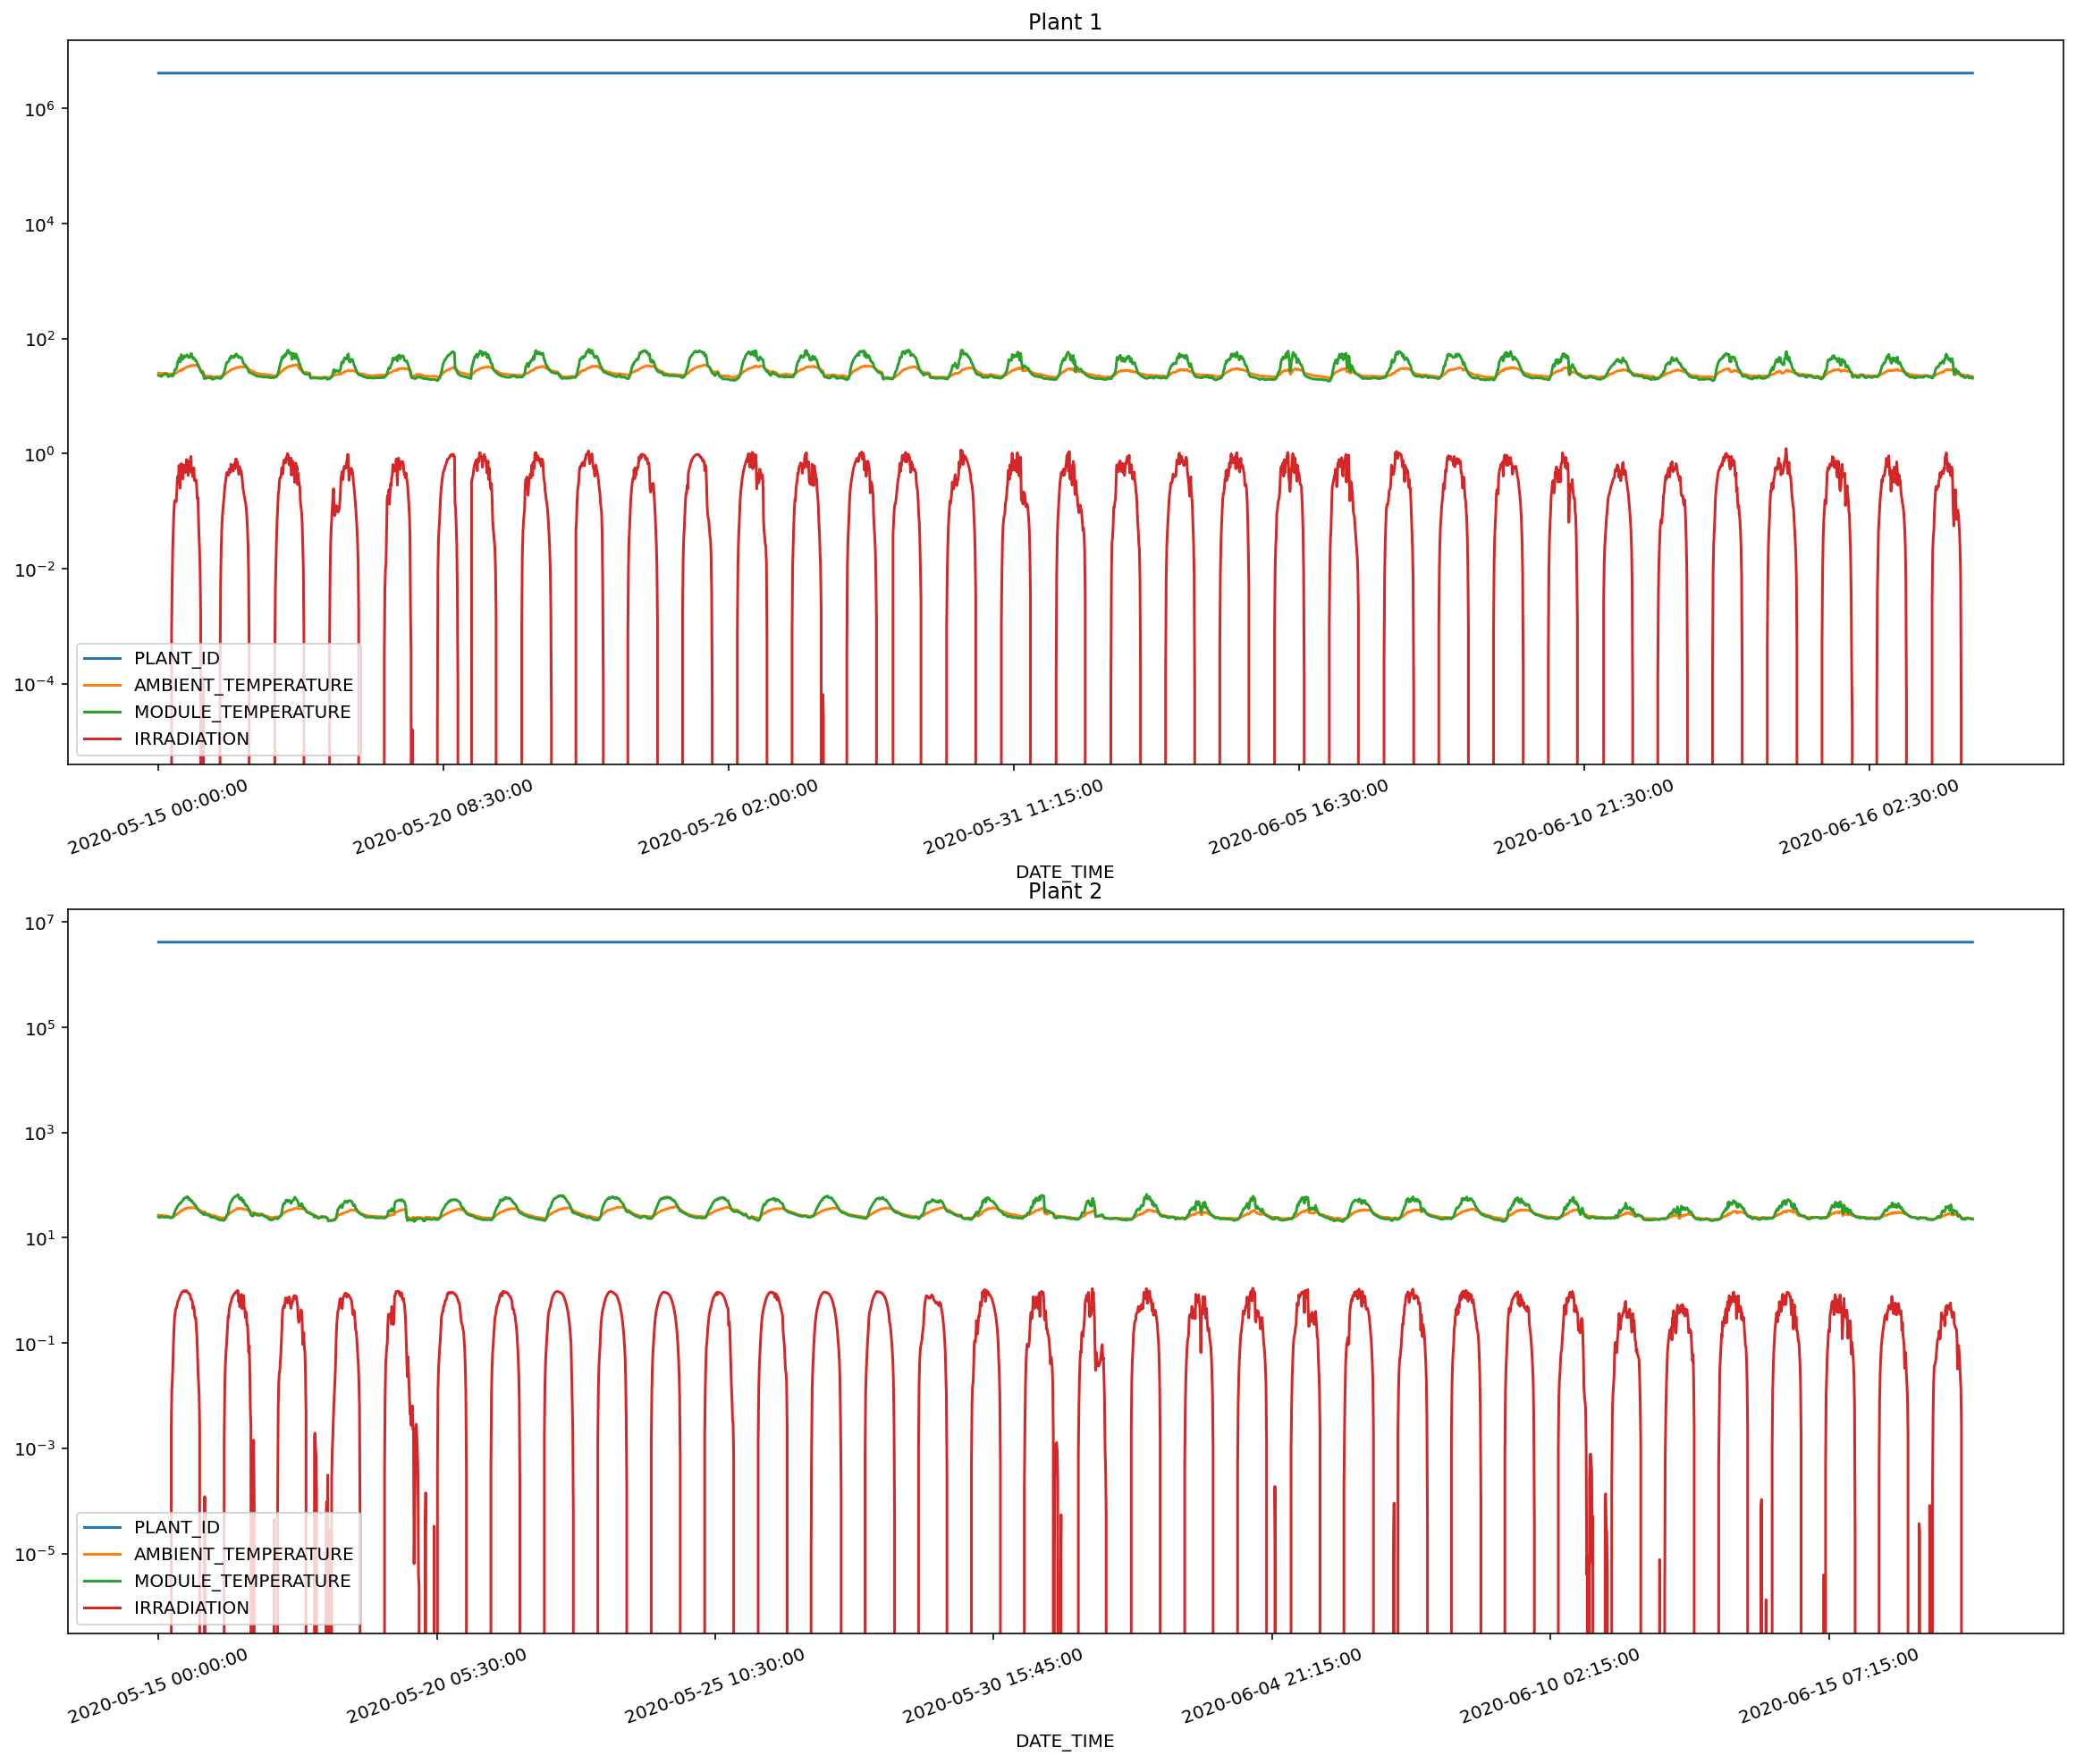

In [6]:
fig, axes = plt.subplots(nrows = 2, sharex=False, figsize=(20, 5))
fig.subplots_adjust(top = 2.6)
ax = plant1_weather.plot(x = 'DATE_TIME', logy = True, title = 'Plant 1', rot = 20, ax = axes[0]); 
ax = plant2_weather.plot(x = 'DATE_TIME', logy = True, title = 'Plant 2', rot = 20, ax = axes[1]); 

- From the plots above we see distinct peaks in power output, irradiation and temperature, rising and falling with the sun each day
- We can also see in the comparisons between plant 1 and plant 2, that for plant 1 TOTAL_YIELD is consistently > ~10^6 whilst for plant 2 TOTAL_YIELD varies dramatically with several interludes where it falls to zero and at other times in the 10^6 - >10^8 range. 
- Daily weather trends on the other hand appear superficially similar between plant 1 and plant 2

#### Lets looks at some aggreate values comparing the two plants

In [7]:
power_metrics =  plant1_generation.columns[3:]
weather_metrics = plant1_weather.columns[3:]

In [8]:
print(power_metrics)
print(weather_metrics)

Index(['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD'], dtype='object')
Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'], dtype='object')


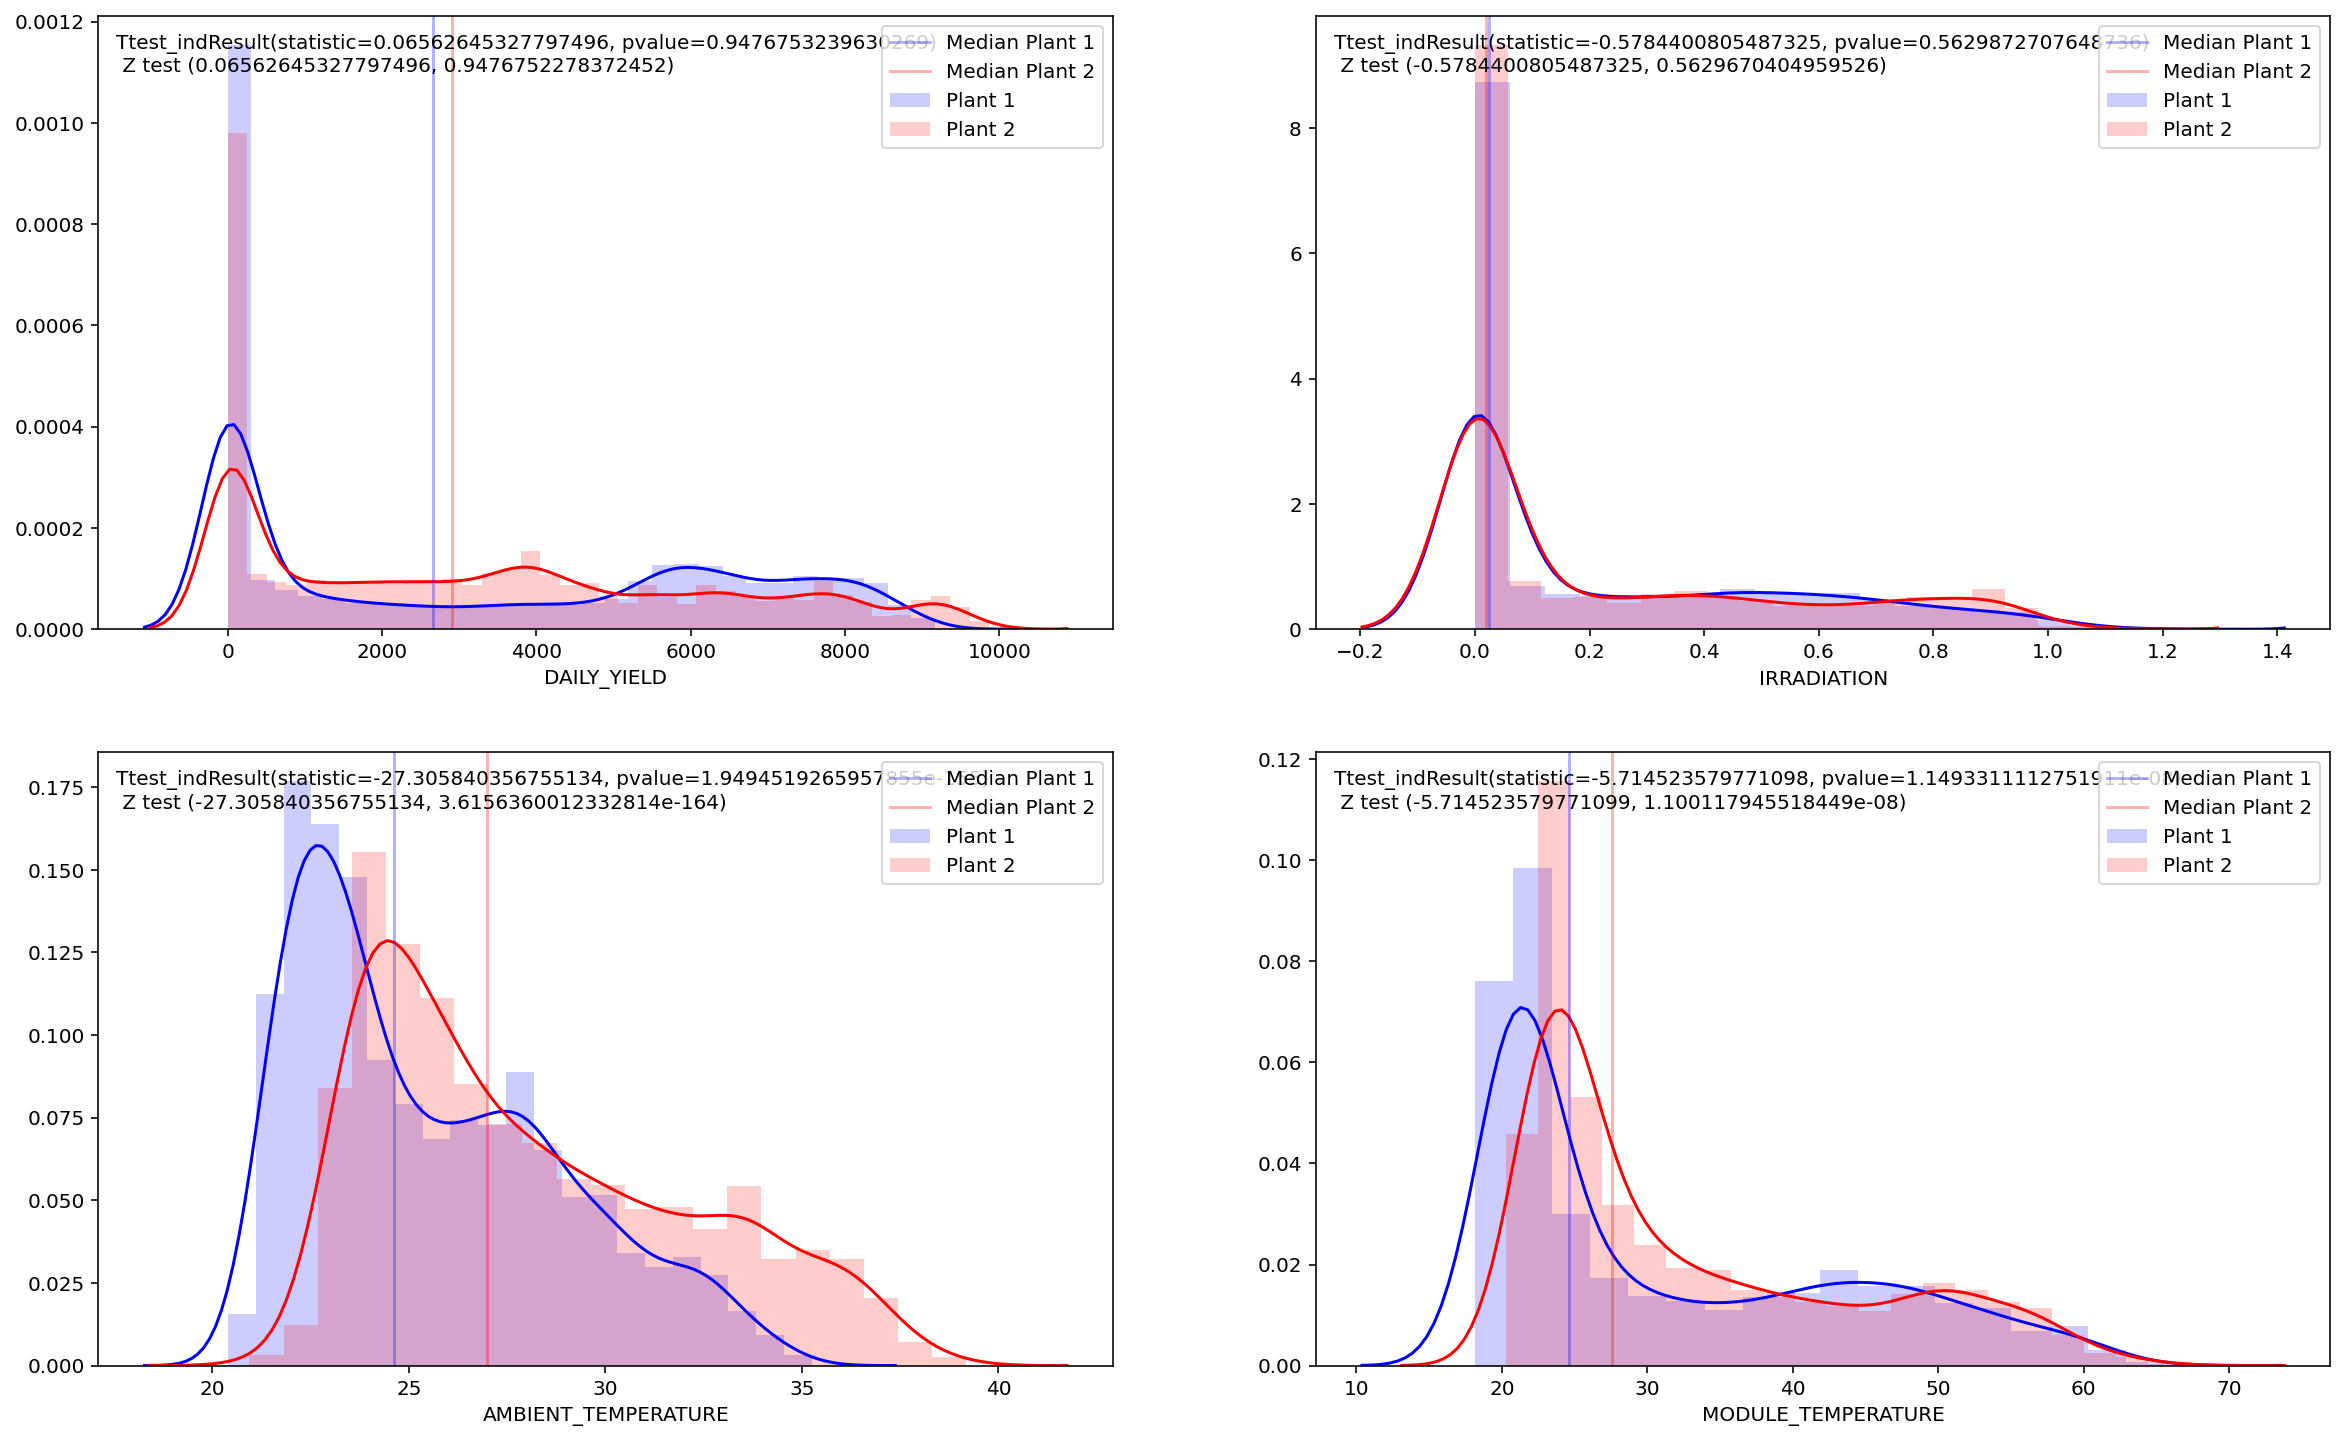

In [9]:
# Overlay of TOTAL_YIELD for plant 1 vs plant 2, with IRRADIATION for plant 1 vs plant 2 next to it
# ANOVA for both plant 1 v 2 comparisons below
from scipy import stats
from matplotlib.offsetbox import AnchoredText
from statsmodels.stats.weightstats import ztest

DY_t = stats.ttest_ind(plant1_generation['DAILY_YIELD'],plant2_generation['DAILY_YIELD'])
DY_z = ztest(plant1_generation['DAILY_YIELD'],plant2_generation['DAILY_YIELD'])
# DY_v_1, DY_v_2 = np.var(plant1_generation['DAILY_YIELD']), np.var(plant2_generation['DAILY_YIELD'])
DY_m_1, DY_m_2 = plant1_generation['DAILY_YIELD'].median(), plant2_generation['DAILY_YIELD'].median()

IR_t = stats.ttest_ind(plant1_weather['IRRADIATION'],plant2_weather['IRRADIATION'])
IR_z = ztest(plant1_weather['IRRADIATION'],plant2_weather['IRRADIATION'])
IR_m_1, IR_m_2 = plant1_weather['IRRADIATION'].median(), plant2_weather['IRRADIATION'].median()

AT_t = stats.ttest_ind(plant1_weather['AMBIENT_TEMPERATURE'],plant2_weather['AMBIENT_TEMPERATURE'])
AT_z = ztest(plant1_weather['AMBIENT_TEMPERATURE'],plant2_weather['AMBIENT_TEMPERATURE'])
AT_m_1, AT_m_2 = plant1_weather['AMBIENT_TEMPERATURE'].median(), plant2_weather['AMBIENT_TEMPERATURE'].median()

MT_t = stats.ttest_ind(plant1_weather['MODULE_TEMPERATURE'],plant2_weather['MODULE_TEMPERATURE'])
MT_z = ztest(plant1_weather['MODULE_TEMPERATURE'],plant2_weather['MODULE_TEMPERATURE'])
MT_m_1, MT_m_2 = plant1_weather['MODULE_TEMPERATURE'].median(), plant2_weather['MODULE_TEMPERATURE'].median()

fig, axes = plt.subplots(ncols = 2, nrows = 2, sharex=False, figsize=(20, 5))
fig.subplots_adjust(top = 2)
Alpha = 0.3

anc1 = AnchoredText(f"{DY_t}\n Z test {DY_z}", loc="upper left", frameon=False)
ax1 = sns.distplot(plant1_generation['DAILY_YIELD'], ax=axes[0,0], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax1 = sns.distplot(plant2_generation['DAILY_YIELD'], ax=axes[0,0], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
fig.axes[0].axvline(DY_m_1, color = 'b', alpha=Alpha, label = 'Median Plant 1')
fig.axes[0].axvline(DY_m_2, color = 'r', alpha=Alpha, label = 'Median Plant 2')
ax1.add_artist(anc1)
ax1.legend()

anc2 = AnchoredText(f"{IR_t}\n Z test {IR_z}", loc="upper left", frameon=False)
ax2 = sns.distplot(plant1_weather['IRRADIATION'], ax=axes[0,1], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax2 = sns.distplot(plant2_weather['IRRADIATION'], ax=axes[0,1], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
fig.axes[1].axvline(IR_m_1, color = 'b', alpha=Alpha, label = 'Median Plant 1')
fig.axes[1].axvline(IR_m_2, color = 'r', alpha=Alpha, label = 'Median Plant 2')
ax2.add_artist(anc2)
ax2.legend()

anc3 = AnchoredText(f"{AT_t}\n Z test {AT_z}", loc="upper left", frameon=False)
ax3 = sns.distplot(plant1_weather['AMBIENT_TEMPERATURE'], ax=axes[1,0], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax3 = sns.distplot(plant2_weather['AMBIENT_TEMPERATURE'], ax=axes[1,0], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
fig.axes[2].axvline(AT_m_1, color = 'b', alpha=Alpha, label = 'Median Plant 1')
fig.axes[2].axvline(AT_m_2, color = 'r', alpha=Alpha, label = 'Median Plant 2')
ax3.add_artist(anc3)
ax3.legend()

anc4 = AnchoredText(f"{MT_t}\n Z test {MT_z}", loc="upper left", frameon=False)
ax4 = sns.distplot(plant1_weather['MODULE_TEMPERATURE'], ax=axes[1,1], color = 'b', label = 'Plant 1', hist_kws=dict(alpha=0.2))
ax4 = sns.distplot(plant2_weather['MODULE_TEMPERATURE'], ax=axes[1,1], color = 'r', label = 'Plant 2', hist_kws=dict(alpha=0.2))
fig.axes[3].axvline(MT_m_1, color = 'b', alpha=Alpha, label = 'Median Plant 1')
fig.axes[3].axvline(MT_m_2, color = 'r', alpha=Alpha, label = 'Median Plant 2')
ax4.add_artist(anc4)
ax4.legend();

- From the distributions and t test results above we can see that although the mean DAILY_YIELD of the two plants is similar, the median DAILY_YIELD for plant 2 is higher
- The levels of IRRADIATION between the two plants are very similar, though plant 2 has slightly higher irradiation levels > ~0.8
- AMBIENT_TEMPERATURE and MODULE_TEMPERATURE are more variable between plant 1 and plant 2
- Plant 2 has a warmer AMBIENT_TEMPERATURE and MODULE_TEMPERATURE on average. 
- Could these occasional days where ambient temperature rises above 35degC and the higher average module temperature, be the reason for the increased variance in power output from plant 2? Perhaps the equipment is over-heating causing it to be less efficient or fail when its preferred operational temperature is exceeded, leading to the drops in TOTAL_YIELD seen in the plot above?

# Forecasting Power Output With Facebook Prophet

- Prophet conducts a form of Bayesian time series forecasting, modelling the change in your chosen variable y, with respect to time, using the following summation:

$y(t) = g(t) + s(t) + h(t) + \epsilon_t \tag{1}$

- $ g(t) $ refers to a piece-wise linear/logistic growth model, $ s(t) $ captures seasonality effects, $ h(t) $ models special events (fb calls them holidays) and $\epsilon_t$ models the error
- This type of model is called a generalised additive model and to learn more and build this from scratch in PyMC3, I recommend this link:
https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/

In [10]:
df = plant2_generation.copy()  
df.rename(columns= {'DATE_TIME':'ds', 'DAILY_YIELD': 'y'}, inplace = True)
m = Prophet(daily_seasonality=True, weekly_seasonality = True, yearly_seasonality = False)
m.fit(df)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

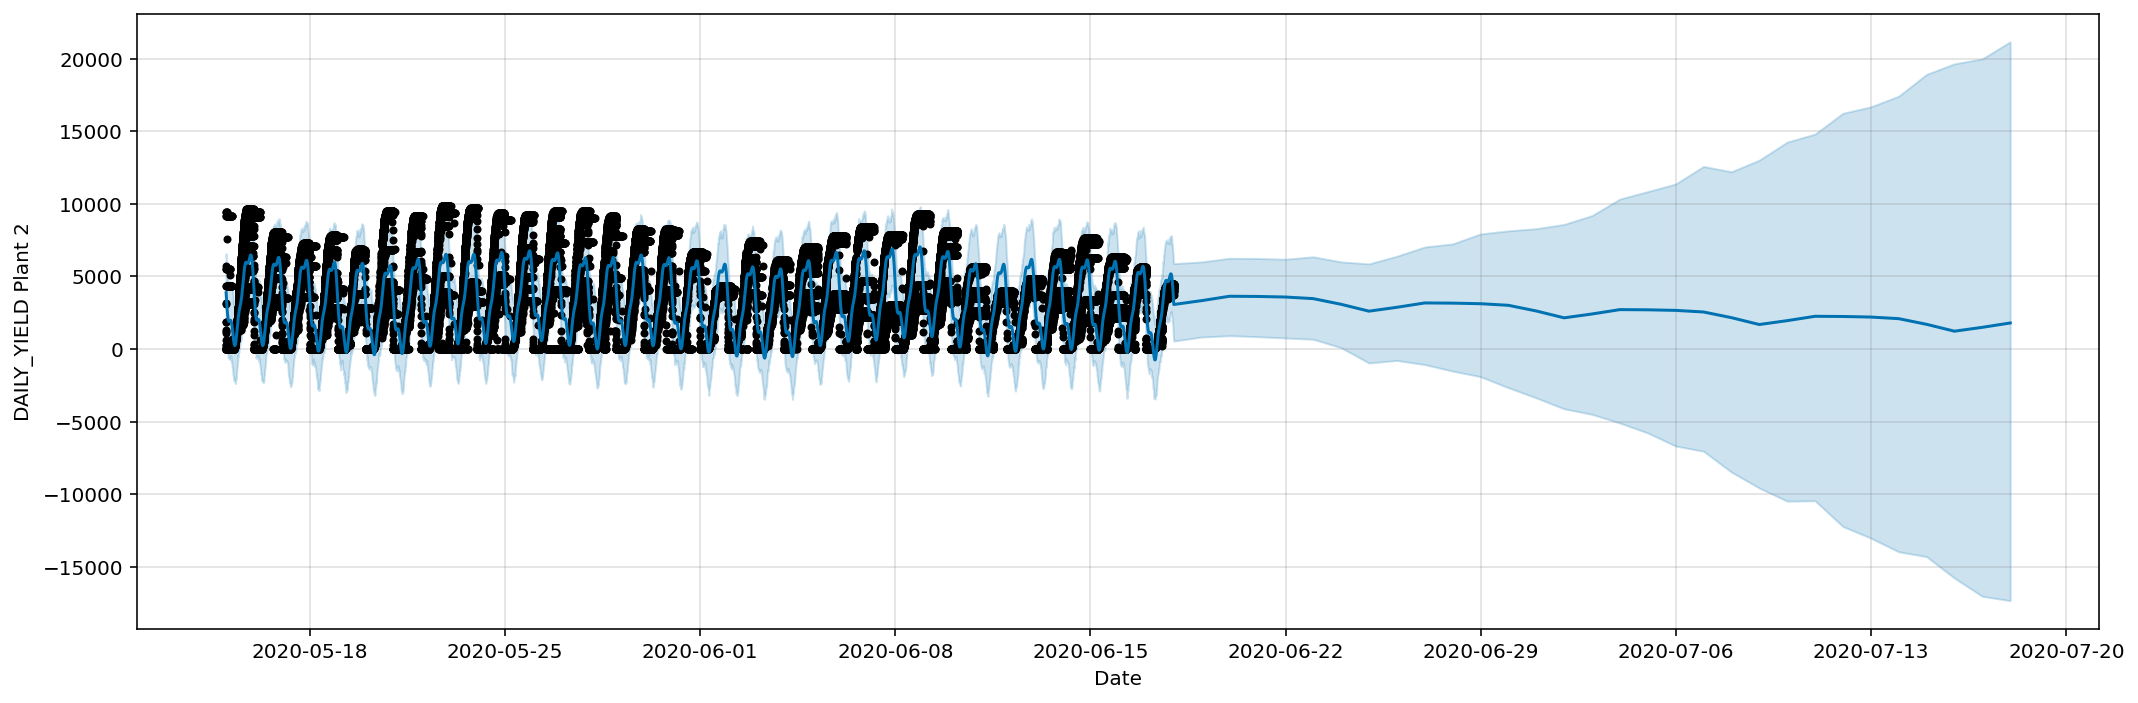

In [11]:
fig1 = m.plot(forecast, xlabel='Date', ylabel='DAILY_YIELD Plant 2',figsize = (15,5))
ax = fig.gca()
ax.set_title("DAILY_YIELD Forecast", size=34)
ax.set_xlabel("X", size=34)
ax.set_ylabel("Y", size=34)
ax.tick_params(axis="x", labelsize=24)
ax.tick_params(axis="y", labelsize=24)

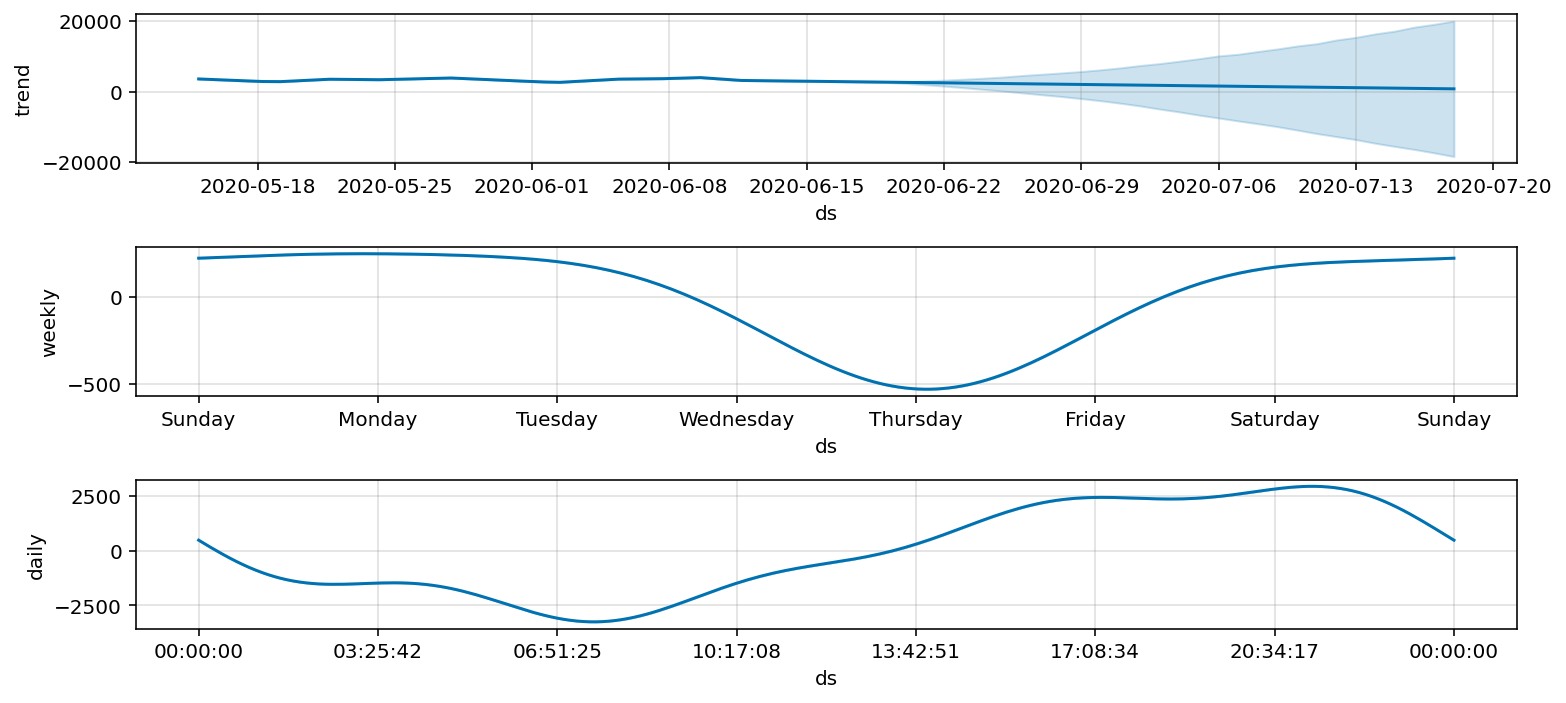

In [12]:
fig2 = m.plot_components(forecast, figsize = (11,5))

# Detecting anomalous MODULE_TEMPERATURE with Facebook Prophet

- Aside from setting thresholds, whereby if a value is crossed an anomaly is registered, more sophisticated time series anomaly detection can be achieved using models which capture the trend in the data through time and assign confidence intervals, outside of which values are classed as anomalies

- fbprophet can also be used for anomaly detection quite easily
https://facebook.github.io/prophet/docs/outliers.html

- Many thanks to the authors of https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f and https://www.mikulskibartosz.name/prophet-plot-explained/ for the starter code used in this section

In [19]:
df2 = plant2_weather.copy()  
df2.rename(columns= {'DATE_TIME':'ds', 'MODULE_TEMPERATURE': 'y'}, inplace = True)

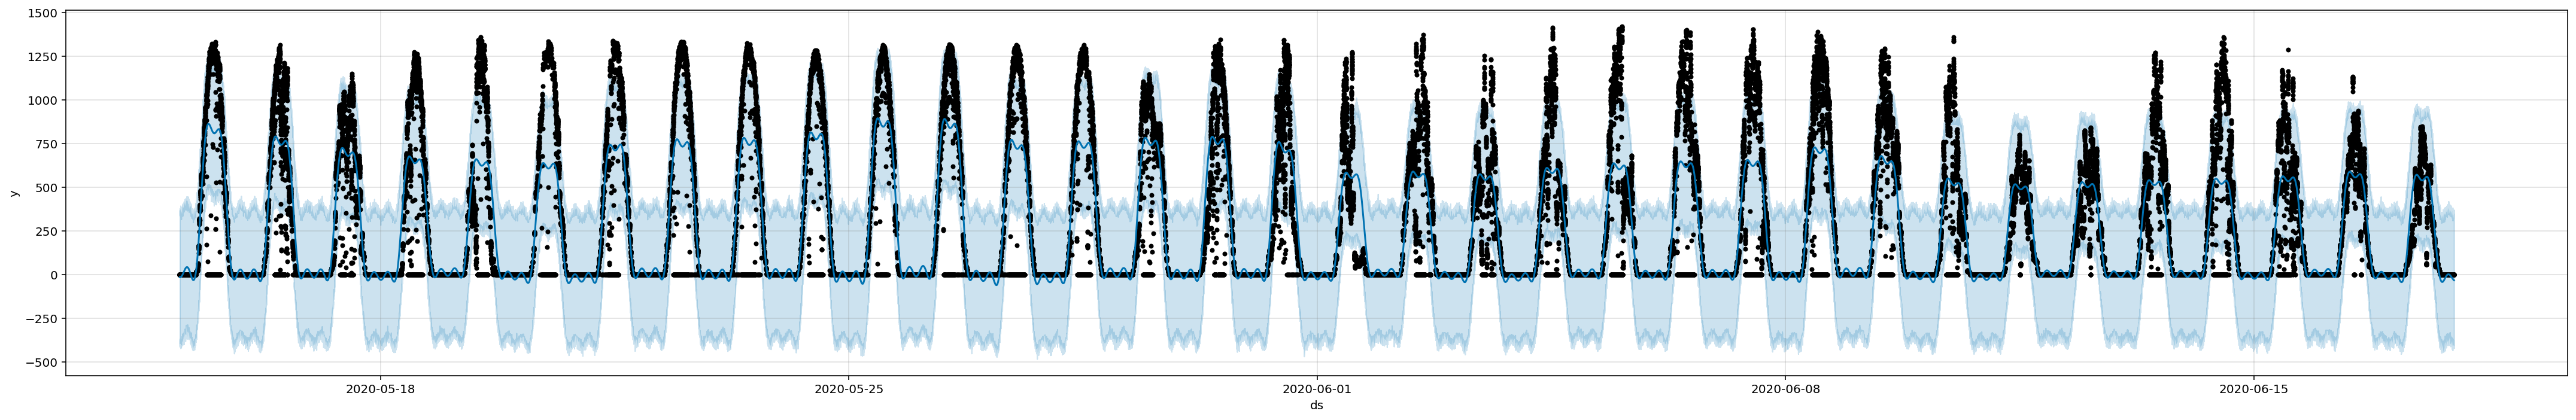

In [186]:
def fit_predict_model(dataframe, interval_width = 0.9, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = True, yearly_seasonality = False, weekly_seasonality = True,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    fig1 = m.plot(forecast, figsize = (30, 5));
    return forecast
    
pred = fit_predict_model(df2)

In [76]:
pred

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0     2020-05-15 00:00:00  321.078067 -352.788949  362.126524   321.078067   
1     2020-05-15 00:00:00  321.078067 -417.403632  362.757677   321.078067   
2     2020-05-15 00:00:00  321.078067 -359.784356  335.644171   321.078067   
3     2020-05-15 00:00:00  321.078067 -389.068904  329.458641   321.078067   
4     2020-05-15 00:00:00  321.078067 -383.085408  339.029114   321.078067   
...                   ...         ...         ...         ...          ...   
67693 2020-06-17 23:45:00  217.438854 -406.139555  329.339767   217.438854   
67694 2020-06-17 23:45:00  217.438854 -409.276190  346.101219   217.438854   
67695 2020-06-17 23:45:00  217.438854 -419.433845  349.699764   217.438854   
67696 2020-06-17 23:45:00  217.438854 -407.294864  355.289321   217.438854   
67697 2020-06-17 23:45:00  217.438854 -423.171919  334.514153   217.438854   

       trend_upper     daily  daily_lower  daily_upper  multiplicative_terms  \
0       321.078067 -1.091233    -1.091233    -1.091233             -1.049446   
1       321.078067 -1.091233    -1.091233    -1.091233             -1.049446   
2       321.078067 -1.091233    -1.091233    -1.091233             -1.049446   
3       321.078067 -1.091233    -1.091233    -1.091233             -1.049446   
4       321.078067 -1.091233    -1.091233    -1.091233             -1.049446   
...            ...       ...          ...          ...                   ...   
67693   217.438854 -1.081262    -1.081262    -1.081262             -1.152814   
67694   217.438854 -1.081262    -1.081262    -1.081262             -1.152814   
67695   217.438854 -1.081262    -1.081262    -1.081262             -1.152814   
67696   217.438854 -1.081262    -1.081262    -1.081262             -1.152814   
67697   217.438854 -1.081262    -1.081262    -1.081262             -1.152814   

       multiplicative_terms_lower  multiplicative_terms_upper    weekly  \
0                       -1.049446                   -1.049446  0.041787   
1                       -1.049446                   -1.049446  0.041787   
2                       -1.049446                   -1.049446  0.041787   
3                       -1.049446                   -1.049446  0.041787   
4                       -1.049446                   -1.049446  0.041787   
...                           ...                         ...       ...   
67693                   -1.152814                   -1.152814 -0.071552   
67694                   -1.152814                   -1.152814 -0.071552   
67695                   -1.152814                   -1.152814 -0.071552   
67696                   -1.152814                   -1.152814 -0.071552   
67697                   -1.152814                   -1.152814 -0.071552   

       weekly_lower  weekly_upper  additive_terms  additive_terms_lower  \
0          0.041787      0.041787             0.0                   0.0   
1          0.041787      0.041787             0.0                   0.0   
2          0.041787      0.041787             0.0                   0.0   
3          0.041787      0.041787             0.0                   0.0   
4          0.041787      0.041787             0.0                   0.0   
...             ...           ...             ...                   ...   
67693     -0.071552     -0.071552             0.0                   0.0   
67694     -0.071552     -0.071552             0.0                   0.0   
67695     -0.071552     -0.071552             0.0                   0.0   
67696     -0.071552     -0.071552             0.0                   0.0   
67697     -0.071552     -0.071552             0.0                   0.0   

       additive_terms_upper       yhat  fact  
0                       0.0 -15.876060   0.0  
1                       0.0 -15.876060   0.0  
2                       0.0 -15.876060   0.0  
3                       0.0 -15.876060   0.0  
4                       0.0 -15.876060   0.0  
...                     ...        ...   

In [189]:
def fbplot(
    m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y',
    figsize=(10, 6)
):
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    #ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.', color = 'r', alpha=0.2)
    #history_df = pd.DataFrame(m.history)
    #history_df.head()
    fcst_df = pd.DataFrame(fcst)
    for i, j in fcst_df.iterrows():
        #print(i)
        if j['anomaly'] == 1 | j['anomaly'] == -1:
            ax.plot(fcst['ds'].iloc[i], fcst['yhat'].iloc[i], color = 'r')
        else:
            ax.plot(fcst['ds'].iloc[i], fcst['yhat'].iloc[i], color = 'b')
            
    #ax.plot(fcst_t, fcst_df['yhat'], ls='-', c='#0072B2')
#     if 'cap' in fcst and plot_cap:
#         ax.plot(fcst_t, fcst['cap'], ls='--', c='k')
#     if m.logistic_floor and 'floor' in fcst and plot_cap:
#         ax.plot(fcst_t, fcst['floor'], ls='--', c='k')
#     if uncertainty:
#         ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
#                         color='#0072B2', alpha=0.2)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig

In [191]:
# Thanks to this blog post for the code here https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [185]:
m.history['y'][1000]

0.0

In [ ]:
fig = plt.figure(facecolor='w', figsize=(20, 5))
ax = fig.add_subplot(111)
for i, j in pred.iterrows():
    #print(i, j['anomaly'])
    plt(pred['ds'].iloc[i], pred['yhat'])
#     if j['anomaly'] == 1 or j['anomaly'] == -1:
#         print('it works')
#         plt.plot(pred['ds'].iloc[i], pred['yhat'].iloc[i], color = 'r')
#     else:
#         plt.plot(pred['ds'].iloc[i], pred['yhat'].iloc[i], color = 'b')

2020-05-15 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-15 02:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 02:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 02:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 02:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-15 03:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 03:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 03:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 03:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-15 05:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 05:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 05:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 05:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-15 06:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 06:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 07:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 07:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-15 08:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 08:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 08:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 08:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-15 10:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 10:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 10:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 10:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

Name: yhat, Length: 67698, dtype: float64
2020-05-15 12:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 12:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 12:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 12:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33

2020-05-15 14:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 14:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 14:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 14:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-15 16:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 16:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 16:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 16:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

Name: yhat, Length: 67698, dtype: float64
2020-05-15 18:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 18:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 18:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 18:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33

2020-05-15 19:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 19:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 19:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 19:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-15 21:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 21:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 21:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-15 21:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 01:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 01:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 01:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 01:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 02:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 02:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 02:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 02:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 04:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 04:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 04:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 04:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 05:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 05:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 05:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 05:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 07:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 07:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 07:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 07:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 09:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 09:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 09:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 09:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 11:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 11:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 11:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 11:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 12:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 12:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 12:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 12:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 14:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 14:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 14:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 14:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 16:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 16:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 16:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 16:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 17:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 17:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 17:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 17:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 19:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 19:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 19:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 19:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 21:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 21:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 21:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 21:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-16 22:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 22:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 22:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-16 22:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 00:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 01:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 01:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 01:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 01:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

Name: yhat, Length: 67698, dtype: float64
2020-05-17 03:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 03:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 03:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 03:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33

2020-05-17 04:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 04:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 04:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 04:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 06:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 06:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 06:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 06:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 07:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 07:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 07:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 07:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 08:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 08:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 08:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 08:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 10:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 10:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 10:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 10:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 12:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 12:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 12:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 12:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 13:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 13:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 13:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 13:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 15:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 15:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 15:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 15:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 16:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 17:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 17:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 17:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 18:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 18:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 18:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 18:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 20:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 20:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 20:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 20:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 21:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 21:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 21:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 21:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-17 23:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 23:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 23:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-17 23:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 00:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 00:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 00:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 00:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 02:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 02:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 02:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 02:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 03:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 03:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 03:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 03:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 05:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 05:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 05:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 05:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 07:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 07:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 07:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 07:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 09:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 09:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 09:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 09:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 10:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 10:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 10:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 10:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 12:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 12:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 12:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 12:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 14:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 14:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 14:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 14:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 16:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 16:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 16:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 16:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 17:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 17:45:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 18:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 18:00:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 19:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 19:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 19:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 19:30:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

2020-05-18 21:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 21:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 21:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227673
67696   -33.227673
67697   -33.227673
Name: yhat, Length: 67698, dtype: float64
2020-05-18 21:15:00 0       -15.876060
1       -15.876060
2       -15.876060
3       -15.876060
4       -15.876060
           ...    
67693   -33.227673
67694   -33.227673
67695   -33.227

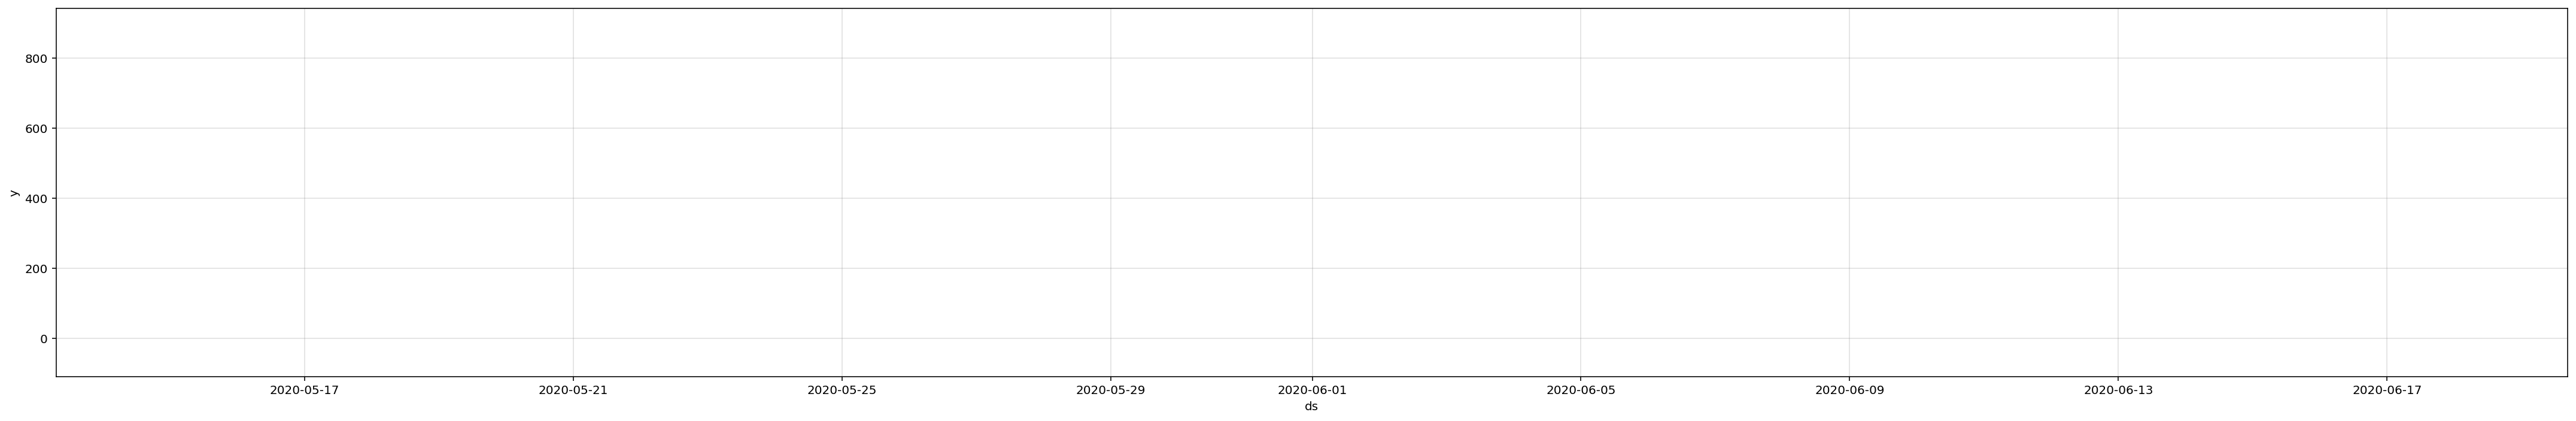

In [192]:
fig1 = fbplot(m, pred, figsize = (30, 5));